# Modeling through Random Forest

## Load Filtered Training Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE

# Notice that install "umap-learn" instead of "umap"
# Default parameters for umap.UMAP(): 
# n_components: 2, n_neighbors: 15, min_dist: 0.1, metric: euclidean

import umap.umap_ as umap

In [2]:
train = pd.read_csv('~/D2K_BCM_DATASET/4kEnsembleId.tsv', sep = '\t', index_col = [0])
train = train.transpose()
train.index.name = 'r_id'
train.reset_index(inplace = True)
train['MGS_LEVEL'] = np.array([int(s[-1]) for s in list(train['r_id'])])
train.head()

,r_id,ENSG00000000003,ENSG00000001036,ENSG00000001084,ENSG00000001629,ENSG00000001631,ENSG00000002586,ENSG00000002933,ENSG00000003400,ENSG00000003509,...,ENSG00000283486,ENSG00000283578,ENSG00000283611,ENSG00000283631,ENSG00000283635,ENSG00000283654,ENSG00000283674,ENSG00000283684,ENSG00000283692,MGS_LEVEL
0,205_2,9.698730,9.007920,11.074547,11.255878,10.578447,9.698730,9.853723,5.876924,9.770795,...,9.213259,0.0,0.000000,0.0,2.014479,0.0,6.376592,0.0,3.339286,2
1,251_1,9.181011,8.480250,10.224124,10.854084,10.851306,9.135288,9.296297,5.330312,9.875868,...,8.289156,0.0,2.814728,0.0,2.006454,0.0,6.358106,0.0,2.814728,1
2,474_3,8.998180,8.114741,10.315019,10.832309,10.474078,8.410391,9.031668,6.190813,9.971107,...,9.550266,0.0,2.808214,0.0,0.000000,0.0,6.285467,0.0,3.322830,3
3,178_4,8.623853,7.775116,10.114775,10.970147,10.669332,8.469199,8.489462,6.511398,10.078450,...,9.065750,0.0,0.000000,0.0,2.587999,0.0,7.421474,0.0,3.090678,4
4,313_1,9.265740,8.237808,10.334186,11.156822,10.967349,8.282984,9.324540,5.706331,10.097601,...,9.771254,0.0,0.000000,0.0,2.887836,0.0,6.282053,0.0,4.087801,1


## Train Different Random Forest Models

In [3]:
name = ['rf', 'brf', 'rf.smote', 'brf.smote']
color = ['red', 'yellow', 'blue', 'green']

In [4]:
# k: The number of folds in cross validation (at least 2)
# tree_num: The number of trees in random forest
# tree_depth: The maximum depth of trees in random forest
# ranking_limit: The number of genes you want to check from top to bottom in the ranking of importance
# seed: Random seed tha ensures our result is reproducible
# verbose: If you want to extra information including visualization and accuracy score

def modeling(k = 10, tree_num = 32, tree_depth = 16, feature_num = 3200, 
             ranking_limit = 300, seed = 123, verbose = False):
    
    X = np.vstack([train[train.MGS_LEVEL == i].drop(['r_id', 'MGS_LEVEL'], axis = 1) for i in range(1, 5)])
    y = np.concatenate([np.full(len(train[train.MGS_LEVEL == i]), i) for i in range(1, 5)])
    features = train.drop(['r_id', 'MGS_LEVEL'], axis = 1).columns
    result, CM, ranking = dict(), dict(), dict()
    
    if (verbose):
        X_embedded = umap.UMAP().fit_transform(X)
        fig, ax = plt.subplots(figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
        pc1 = ax.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], label = 'No AMD / normal')
        pc2 = ax.scatter(X_embedded[y == 2, 0], X_embedded[y == 2, 1], label = 'Early stage AMD')
        pc3 = ax.scatter(X_embedded[y == 3, 0], X_embedded[y == 3, 1], label = 'Intermediate AMD')
        pc4 = ax.scatter(X_embedded[y == 4, 0], X_embedded[y == 4, 1], label = 'Advanced AMD')
        ax.set_title("Dimentional Reduction Based on Original Training Data")
        ax.legend()
        plt.show()
    
    # Modeling with original data
    
    # Random Forest
    
    rf = RandomForestClassifier(
        n_estimators = tree_num, 
        max_depth = tree_depth,
        max_features = feature_num,
        random_state = seed)
    
    acc = []
    CM['rf'] = [[0, 0, 0, 0] for i in range(4)]
    importance = [0 for i in range(len(features))]
    cv = KFold(n_splits = k, random_state = seed, shuffle = True)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        acc.append(metrics.accuracy_score(y_test, y_pred))
        for i, j in zip(y_pred, y_test):
            CM['rf'][i - 1][j - 1] += 1
        importance = [sum(i) for i in zip(importance, rf.feature_importances_)]
    
    result['rf'] = sum(acc) / k
    for i in range(4):
        for j in range(4):
            CM['rf'][i][j] /= k
    
    importance = list(map(lambda x : x / k, importance))
    indices = np.argsort(importance)[::-1]
    ranking['rf'] = [features[indices[i]] for i in range(ranking_limit)]
    if (verbose):
        print("Random Forest (original): \n")
        print("Feature ranking: \n")
        for i in range(ranking_limit):
            print("%d. %s (%f)" % (i + 1, features[indices[i]], importance[indices[i]]))
        print()
    
    # Balanced Random Forest
    
    brf = BalancedRandomForestClassifier(
        n_estimators = tree_num, 
        max_depth = tree_depth,
        max_features = feature_num,
        random_state = seed)
    
    acc = []
    CM['brf'] = [[0, 0, 0, 0] for i in range(4)]
    importance = [0 for i in range(len(features))]
    cv = KFold(n_splits = k, random_state = seed, shuffle = True)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        brf.fit(X_train, y_train)
        y_pred = brf.predict(X_test)
        acc.append(metrics.accuracy_score(y_test, y_pred))
        for i, j in zip(y_pred, y_test):
            CM['brf'][i - 1][j - 1] += 1
        importance = [sum(i) for i in zip(importance, brf.feature_importances_)]
        
    result['brf'] = sum(acc) / k
    for i in range(4):
        for j in range(4):
            CM['brf'][i][j] /= k
    
    importance = list(map(lambda x : x / k, importance))
    indices = np.argsort(importance)[::-1]
    ranking['brf'] = [features[indices[i]] for i in range(ranking_limit)]
    if (verbose):
        print("Balanced Random Forest (original): \n")
        print("Feature ranking: \n")
        for i in range(ranking_limit):
            print("%d. %s (%f)" % (i + 1, features[indices[i]], importance[indices[i]]))
        print()
        
    # SMOTE
    
    sm = SMOTE(random_state = 123)
    
    # Random Forest
    
    rf = RandomForestClassifier(
        n_estimators = tree_num, 
        max_depth = tree_depth,
        max_features = feature_num,
        random_state = seed)
    
    acc = []
    CM['rf.smote'] = [[0, 0, 0, 0] for i in range(4)]
    importance = [0 for i in range(len(features))]
    cv = KFold(n_splits = k, random_state = seed, shuffle = True)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        X_train, y_train = sm.fit_resample(X_train, y_train)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        acc.append(metrics.accuracy_score(y_test, y_pred))
        for i, j in zip(y_pred, y_test):
            CM['rf.smote'][i - 1][j - 1] += 1
        importance = [sum(i) for i in zip(importance, rf.feature_importances_)]
        
    result['rf.smote'] = sum(acc) / k
    for i in range(4):
        for j in range(4):
            CM['rf.smote'][i][j] /= k

    importance = list(map(lambda x : x / k, importance))
    indices = np.argsort(importance)[::-1]
    ranking['rf.smote'] = [features[indices[i]] for i in range(ranking_limit)]
    if (verbose):
        print("Random Forest (SMOTE): \n")
        print("Feature ranking: \n")
        for i in range(ranking_limit):
            print("%d. %s (%f)" % (i + 1, features[indices[i]], importance[indices[i]]))
        print()
    
    # Balanced Random Forest
    
    brf = BalancedRandomForestClassifier(
        n_estimators = tree_num, 
        max_depth = tree_depth,
        max_features = feature_num,
        random_state = seed)
    
    acc = []
    CM['brf.smote'] = [[0, 0, 0, 0] for i in range(4)]
    importance = [0 for i in range(len(features))]
    cv = KFold(n_splits = k, random_state = seed, shuffle = True)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        X_train, y_train = sm.fit_resample(X_train, y_train)
        brf.fit(X_train, y_train)
        y_pred = brf.predict(X_test)
        acc.append(metrics.accuracy_score(y_test, y_pred))
        for i, j in zip(y_pred, y_test):
            CM['brf.smote'][i - 1][j - 1] += 1
        importance = [sum(i) for i in zip(importance, brf.feature_importances_)]
        
    result['brf.smote'] = sum(acc) / k
    for i in range(4):
        for j in range(4):
            CM['brf.smote'][i][j] /= k
    
    importance = list(map(lambda x : x / k, importance))
    indices = np.argsort(importance)[::-1]
    ranking['brf.smote'] = [features[indices[i]] for i in range(ranking_limit)]
    if (verbose):
        print("Balanced Random Forest (SMOTE): \n")
        print("Feature ranking: \n")
        for i in range(ranking_limit):
            print("%d. %s (%f)" % (i + 1, features[indices[i]], importance[indices[i]]))
        print()
    
    return result, CM, ranking
    

## Tune Parameters

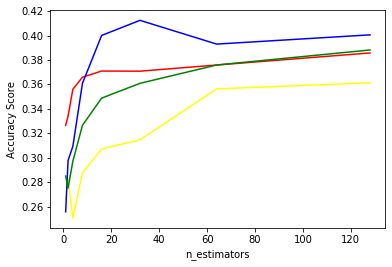

In [22]:
# Number of trees in random forest

n_estimator = [1, 2, 4, 8, 16, 32, 64, 128]
line = [[] for i in range(4)]
for num in n_estimator:
    x = modeling(tree_num = num)
    value = list(x[0].values())
    for i in range(4):
        line[i].append(value[i])
for i in range(4):
    plt.plot(n_estimator, line[i], color = color[i], label = name[i])
plt.xlabel('n_estimators')
plt.ylabel('Accuracy Score')
plt.show()

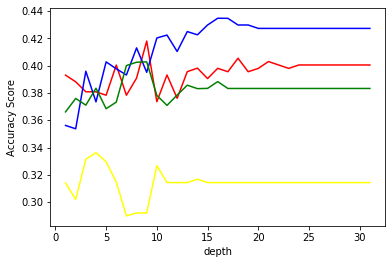

In [24]:
# Depth of trees in random forest

depth = range(1, 32)
line = [[] for i in range(4)]
for d in depth:
    x = modeling(tree_depth = d)
    value = list(x[0].values())
    for i in range(4):
        line[i].append(value[i])

for i in range(4):
    plt.plot(depth, line[i], color = color[i], label = name[i])
plt.xlabel('depth')
plt.ylabel('Accuracy Score')
plt.show()

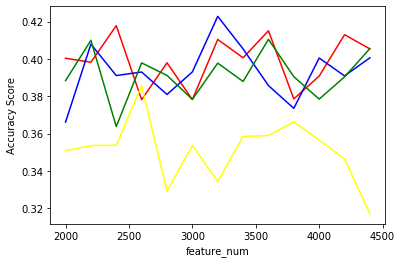

In [28]:
# Maximum number of features that is considered once

feature = range(2000, 4600, 200)
line = [[] for i in range(4)]
for f in feature:
    x = modeling(feature_num = f)
    value = list(x[0].values())
    for i in range(4):
        line[i].append(value[i])

for i in range(4):
    plt.plot(feature, line[i], color = color[i], label = name[i])
plt.xlabel('feature_num')
plt.ylabel('Accuracy Score')
plt.show()

In [6]:
x = modeling()
result, CM, ranking = x[0], x[1], x[2]
for i in range(4):
    print(name[i] + "\n")
    print("Accuracy Score: " + str(result[name[i]]) + "\n")
    print("Confusion Matrix:")
    df = pd.DataFrame()
    for j in range(4):
        df[str(j + 1)] = np.array(CM[name[i]][j])
    df.index = np.array(range(1, 5))
    df = df.transpose()
    display(df)
df2 = pd.DataFrame()
for i in range(4):
    df2[name[i]] = np.array(ranking[name[i]])
    df2.index = np.array(range(1, 301))
display(df2)

rf

Accuracy Score: 0.400670731707317

Confusion Matrix:


,1,2,3,4
1,2.1,2.0,1.8,0.7
2,6.2,11.5,4.9,3.3
3,1.4,2.3,2.5,1.0
4,0.0,0.2,0.6,0.2


brf

Accuracy Score: 0.326829268292683

Confusion Matrix:


,1,2,3,4
1,3.4,4.0,3.0,0.6
2,2.7,5.5,2.1,0.8
3,2.2,3.0,2.0,1.4
4,1.4,3.5,2.7,2.4


rf.smote

Accuracy Score: 0.403109756097561

Confusion Matrix:


,1,2,3,4
1,3.3,3.1,2.7,0.4
2,3.8,9.5,3.7,2.5
3,2.4,2.5,2.5,1.2
4,0.2,0.9,0.9,1.1


brf.smote

Accuracy Score: 0.42280487804878053

Confusion Matrix:


,1,2,3,4
1,4.0,3.4,1.9,0.4
2,3.2,9.3,4.0,2.3
3,2.2,2.3,2.7,1.3
4,0.3,1.0,1.2,1.2


,rf,brf,rf.smote,brf.smote
1,ENSG00000121236,ENSG00000079931,ENSG00000079931,ENSG00000079931
2,ENSG00000206337,ENSG00000242575,ENSG00000272239,ENSG00000205976
3,ENSG00000119616,ENSG00000225362,ENSG00000205976,ENSG00000272239
4,ENSG00000241233,ENSG00000236824,ENSG00000260788,ENSG00000206337
5,ENSG00000149646,ENSG00000279030,ENSG00000225362,ENSG00000260788
...,...,...,...,...
296,ENSG00000280623,ENSG00000128573,ENSG00000117009,ENSG00000104714
297,ENSG00000110680,ENSG00000222009,ENSG00000253506,ENSG00000104055
298,ENSG00000159873,ENSG00000167613,ENSG00000112761,ENSG00000100312
299,ENSG00000185436,ENSG00000158516,ENSG00000174013,ENSG00000178440
